<h2 style="color:gree;">Brahim SAADI et Billel NOURINE</h2>

<h1 style="color:blue;">Réalisation d’un système de classification des panneaux routiers</h1><br>
<b>importation des modules</b>

In [45]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2 as cv
import math
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras

from PIL import Image
import glob

In [46]:
# une fonction pour afficher plusieurs images

def imshow(*images, suptitle=None, titles=None, cmap=None, layout=None, figsize=None):
    if cmap == "BGR":
        images = list(images)
        for index, image in enumerate(images):
            images[index] = image[..., ::-1]
    if not layout:
        layout = (len(images), 1)
    if titles and len(titles) != len(images):
        raise ValueError("len(titles) != len(images)")
    
    erreur_msg = "Erreur: layout doit etre un 'int' ou '(int, int)'"
    
    try:
        if len(layout) > 2:
            raise ValueError(erreur_msg)
    except TypeError:
        layout = (layout, 1)
    
    valid = (isinstance(layout[0], int) and 
            (isinstance(layout[1], int) if len(layout) == 2 else True))
    
    if not valid:
        raise ValueError(erreur_msg)
    
    fig, axes = plt.subplots(*layout)
    fig.set_size_inches(
        figsize if figsize else (layout[0]*5, layout[1]*5)
    )
    try:
        axes = axes.ravel()
    except AttributeError:
        axes = (axes,)

    if suptitle:
        fig.suptitle(suptitle)

    if titles:
        for axis, image, title in zip(axes, images, titles):
            axis.imshow(image, cmap=cmap)
            axis.set_title(title)
            axis.set_xticks([])
            axis.set_yticks([])
    else:
        for axis, image in zip(axes, images):
            axis.imshow(image, cmap=cmap)
            axis.set_xticks([])
            axis.set_yticks([])
    plt.show()

<h3>loading images</h3>

In [47]:
avertissement = []
interdiction = []
obligation = []

for filename in glob.glob('Traffic routier/classe avertissement de danger/*.png'):
    im = np.array(Image.open(filename))
    avertissement.append(im)
    
for filename in glob.glob('Traffic routier/classe interdicition ou restriction/*.png'):
    im = np.array(Image.open(filename))
    interdiction.append(im)
    
for filename in glob.glob('Traffic routier/classe obligation/*.png'):
    im = np.array(Image.open(filename))
    obligation.append(im)

In [48]:
images= [*avertissement, *interdiction, *obligation]
len(images)

150

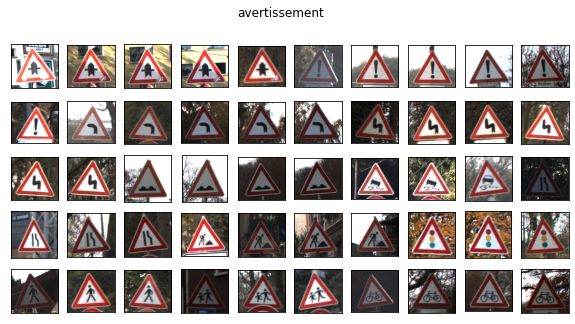

In [49]:
imshow(*avertissement, suptitle= "avertissement", layout=(5, 10), figsize=(10, 5))

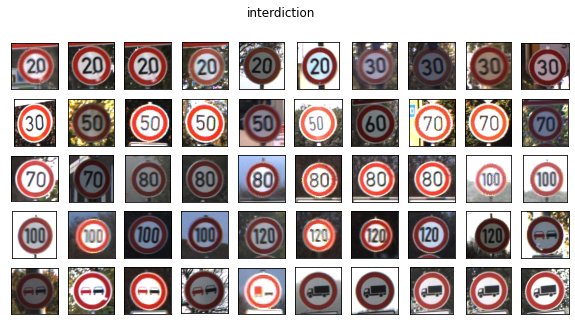

In [50]:
imshow(*interdiction, suptitle= "interdiction", layout=(5, 10), figsize=(10, 5))

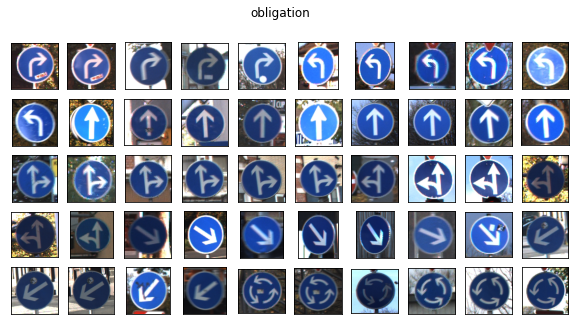

In [51]:
imshow(*obligation, suptitle= "obligation", layout=(5, 10), figsize=(10, 5))

<h1 style="color:blue;">Travail demandé</h1>

<h2 style="color:#00D5FA;">1. Appliquer un filtrage médian.</h2>

In [52]:
# la taille du filtre est 5*5
images_median = []
for index, img in enumerate(images):
    images_median.append(cv.medianBlur(img, 5))

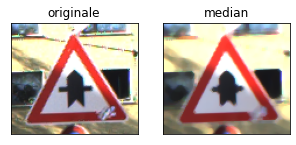

In [53]:
imshow(images[3], images_median[3], titles= ["originale", "median"], layout= (1,2))

<h2 style="color:#00D5FA;">2. Réaliser une conversion de l’espace RGB vers l’espace Y’CbCr</h2>

In [54]:
images_ycrcb = []
for i, image in enumerate(images_median):
    images_ycrcb.append(cv.cvtColor(image, cv.COLOR_RGB2YCR_CB))

<h2 style="color:#00D5FA;">3. Redimensionner les images Y’CbCr obtenues de façon à avoir des images de 64x128 pixels.</h2>

In [55]:
for i in range(150):
    images_ycrcb[i] = cv.resize(images_ycrcb[i], (128, 64))
images_ycrcb[6].shape

(64, 128, 3)

<h2 style="color:#00D5FA;">4. Générer l’histogramme des gradients orientés [9 orientations, cellules = 8x8 pixels, blocs = 16x16 pixels]</h2>

In [56]:
hogImg = []
for img in images_ycrcb:
    hogImg.append(hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True))

<h3 style="color:#00D5FA;">la taille du vecteur caracteristique:</h3>

In [57]:
print("la taille du vacteur caracteristique est",hogImg[0].shape)

la taille du vacteur caracteristique est (3780,)


<h2 style="color:#00D5FA;">5. Diviser les données de chaque classes aléatoirement en 2 ensembles ;
<br><br>train and test split</h2>

In [58]:
data = np.array(hogImg)
labels = np.concatenate([np.zeros(50), np.ones(50), 2*np.ones(50)])
# labels = [0] * 50 + [1] * 50 + [2] * 50

X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=1/3, shuffle=True)

<h2 style="color:#00D5FA;">6. Réaliser une classification avec l’algorithme du k-plus proches voisins</h2>

In [59]:
# creation du model 
accuracy = []
distances = ["manhattan", "euclidean", "canberra"]
confusion_matrices = []
score = []

for k in [1,3,5,7,9] :
    for dist in distances:
        model = KNeighborsClassifier(n_neighbors=k, metric = dist)
        model.fit(X_train, y_train)
        y_predicted = model.predict(X_test)
        score.append(accuracy_score(y_predicted, y_test))
        accuracy.append([k, dist, score])
        confusion_matrices.append([k, dist, confusion_matrix(y_predicted, y_test)])

In [60]:
np.array(score).T

array([1.  , 1.  , 0.98, 0.98, 1.  , 0.98, 0.94, 0.92, 0.94, 0.94, 0.94,
       0.94, 0.92, 0.92, 0.94])

le meilleur score est 100%, pas d'image mal classe

les images mals classées: pour k = 9 et metric = "canberra"

In [61]:
model = KNeighborsClassifier(n_neighbors=9, metric = "canberra")
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
accuracy_score(y_predicted, y_test)

0.94

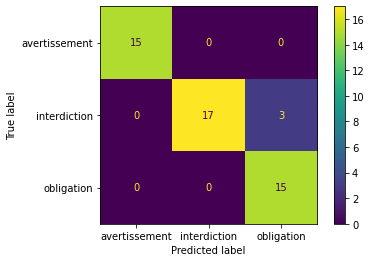

In [62]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_predicted, y_test), display_labels = ["avertissement", "interdiction", "obligation"])

cm_display.plot()
plt.show()

In [63]:
for i in range(y_predicted.shape[0]):
    if y_predicted[i] != y_test[i]:
        print(i)

5
29
45


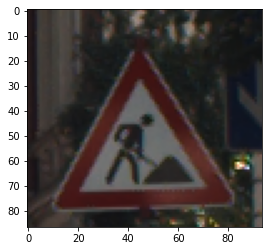

In [64]:
for i , img in enumerate(hogImg):
    if np.all(img == X_test[32]):
        break
plt.imshow(images[i])

cette image est apartient au classe obligation mais elle a ete presenter comme interdication, parceque tous les deux sont sour forma circulaire

<h2 style="color:#00D5FA;">7. Réaliser une classification à l’aide d’un réseau de neurones multicouche</h2>

In [69]:
model = keras.Sequential([
    keras.layers.Dense(64, input_shape=(3780,),activation = 'relu'),
    keras.layers.Dense(3 ,activation = 'sigmoid')
])

Epoch 1/10
4/4 [==============================] - 1s 5ms/step - loss: 0.9228 - accuracy: 0.6100
Epoch 2/10
4/4 [==============================] - 0s 11ms/step - loss: 0.3879 - accuracy: 0.7700
Epoch 3/10
4/4 [==============================] - 0s 11ms/step - loss: 0.1785 - accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 0s 11ms/step - loss: 0.1112 - accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 0s 7ms/step - loss: 0.0516 - accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 0s 8ms/step - loss: 0.0326 - accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 0s 8ms/step - loss: 0.0183 - accuracy: 1.0000
Epoch 8/10
4/4 [==============================] - 0s 8ms/step - loss: 0.0156 - accuracy: 1.0000
Epoch 9/10
4/4 [==============================] - 0s 8ms/step - loss: 0.0123 - accuracy: 1.0000
Epoch 10/10
4/4 [==============================] - 0s 11ms/step - loss: 0.0083 - accuracy: 1.0000


In [73]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                241984    
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
Total params: 242,179
Trainable params: 242,179
Non-trainable params: 0
_________________________________________________________________


In [ ]:

model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

model.fit(np.array(X_train), np.array(y_train), epochs = 10)

In [70]:
y_predicted = np.zeros(50)
predictions = model.predict(X_test)
for i in range(50):
    y_predicted[i] = np.argmax(predictions[i])

2/2 [==============================] - 0s 0s/step


In [71]:
confusion_matrix_RNN = confusion_matrix(y_test, y_predicted)

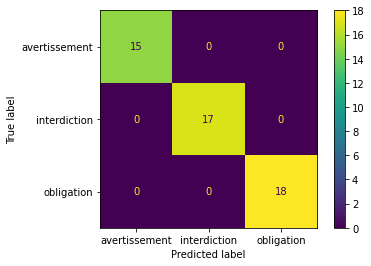

In [72]:
m_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_RNN,
                                           display_labels = ["avertissement", "interdiction", "obligation"])

m_display.plot()
plt.show()